## Tarea 4: Selección de Caractéres

**Tarea en Clase**
- Aplica algún método de filtro de tus datops mediante el uso de SelectKBest

**Tarea**

- 1.1 Aplica los modelos de selección de características cuidando los supuestos de cada modelo
- 1.2 Busca Una o varias métricas para seleccionar características en literatura relacionada con tu problema (citar tus fuentes)
- 1.3 Con base en tu investigación, determina las características más relevantes de tu conjunto de datos
- 1.4 Discute por qué crees que las características seleccionadas son las más relevantes y por qué el resto quedaron excluidas en la selección

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_regression, r_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
import numpy as np

In [64]:
# lectura de datos
df = pd.read_csv('C:/Users/emanuel.novelo/Desktop/MCD - 2024-2026/ML - 2do Tetra/MCD----ML----2024/data/CO2_emission.csv')
df.head()

,Model_Year,Make,Model,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Consumption_in_City(L/100 km),Fuel_Consumption_in_City_Hwy(L/100 km),Fuel_Consumption_comb(L/100km),CO2_Emissions,Smog_Level
0,2021,Acura,ILX,Compact,2.4,4,AM8,9.9,7.0,8.6,199,3
1,2021,Acura,NSX,Two-seater,3.5,6,AM9,11.1,10.8,11.0,256,3
2,2021,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,11.0,8.6,9.9,232,6
3,2021,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,11.3,9.1,10.3,242,6
4,2021,Acura,TLX SH-AWD,Compact,2.0,4,AS10,11.2,8.0,9.8,230,7


### Select KBest

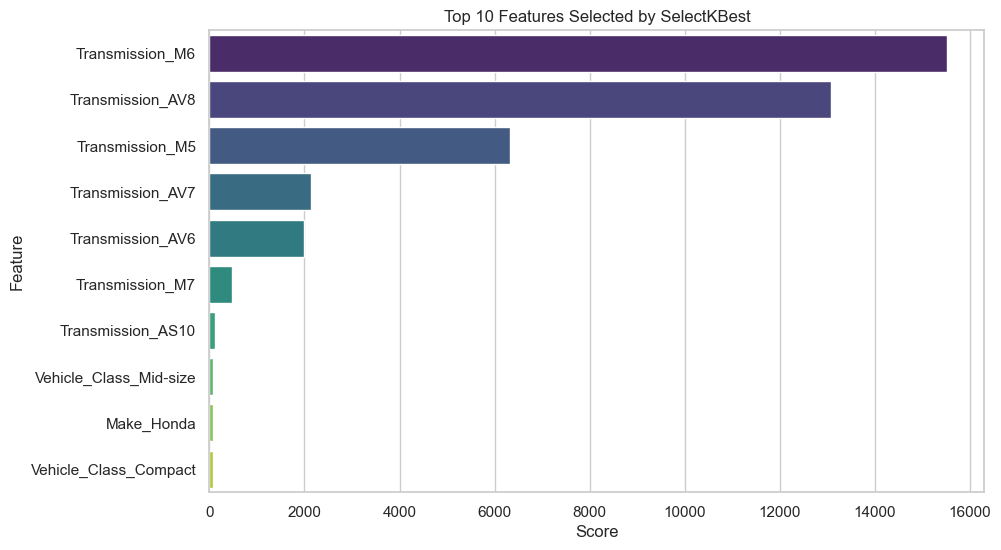

In [55]:
from sklearn.feature_selection import SelectKBest
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns

categorical_features = ["Model_Year", "Make", "Model", "Vehicle_Class", "Transmission"]
numerical_features = [col for col in df.columns if col not in categorical_features + ['CO2_Emissions']] 

y = df['CO2_Emissions']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', SimpleImputer(strategy='median'), numerical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('selector', SelectKBest(score_func=f_regression, k=10))
])

X = df.drop(columns=['CO2_Emissions'])

pipeline.fit(X, y)

selected_columns_indices = pipeline.named_steps['selector'].get_support(indices=True)
selected_scores = pipeline.named_steps['selector'].scores_[selected_columns_indices]

transformed_columns = np.hstack([
    numerical_features,
    pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
])

selected_features = transformed_columns[selected_columns_indices]
selected_features_scores = pd.DataFrame({'Feature': selected_features, 'Score': selected_scores})

selected_features_scores = selected_features_scores.sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=selected_features_scores, palette='viridis')
plt.title('Top 10 Features Selected by SelectKBest')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()


### Métodos de filtro

In [65]:
# Pre-proceso, one hot encoding, pipeline
categorical_features = ["Model_Year", "Make", "Model", "Vehicle_Class", "Transmission"]
numerical_features = [col for col in df.columns if col not in categorical_features + ['CO2_Emissions']] 

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', SimpleImputer(strategy='median'), numerical_features)  
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_processed = pipeline.fit_transform(df)

y = df['CO2_Emissions']

#### ANOVA de valor F

In [35]:
# Aplicando prueba F
F, p_values = f_regression(X_processed, y)

results_df = pd.DataFrame({
    'Feature': np.array(pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features).tolist() + numerical_features),
    'F-value': F,
    'p-value': p_values
})

results_df = results_df.sort_values(by='p-value')

results_df

C:\Users\emanuel.novelo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:331: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


,Feature,F-value,p-value
783,Fuel_Consumption_in_City_Hwy(L/100 km),6319.939042,0.000000e+00
782,Fuel_Consumption_in_City(L/100 km),13080.346820,0.000000e+00
784,Fuel_Consumption_comb(L/100km),15524.585148,0.000000e+00
781,Cylinders,2148.015882,2.944929e-244
780,Engine_Size,1999.320669,3.129471e-234
...,...,...,...
695,Model_Wrangler JL 4X4 eTorque,0.000067,9.934470e-01
233,Model_Charger AWD,0.000067,9.934470e-01
54,Model_300 AWD,0.000067,9.934470e-01
520,Model_Q60 AWD Red Sport,0.000053,9.941751e-01


In [36]:
# Variables que pasaron la prueba F
results_pass_df = results_df[results_df['p-value'] < 0.05]
results_pass_df = results_pass_df.sort_values(by='p-value')

results_pass_df

,Feature,F-value,p-value
783,Fuel_Consumption_in_City_Hwy(L/100 km),6319.939042,0.000000e+00
782,Fuel_Consumption_in_City(L/100 km),13080.346820,0.000000e+00
784,Fuel_Consumption_comb(L/100km),15524.585148,0.000000e+00
781,Cylinders,2148.015882,2.944929e-244
780,Engine_Size,1999.320669,3.129471e-234
...,...,...,...
272,Model_Cullinan,3.929128,4.774957e-02
273,Model_Cullinan Black Badge,3.929128,4.774957e-02
265,Model_Corolla Hatchback,3.924081,4.789249e-02
342,Model_Flying Spur,3.875316,4.929678e-02


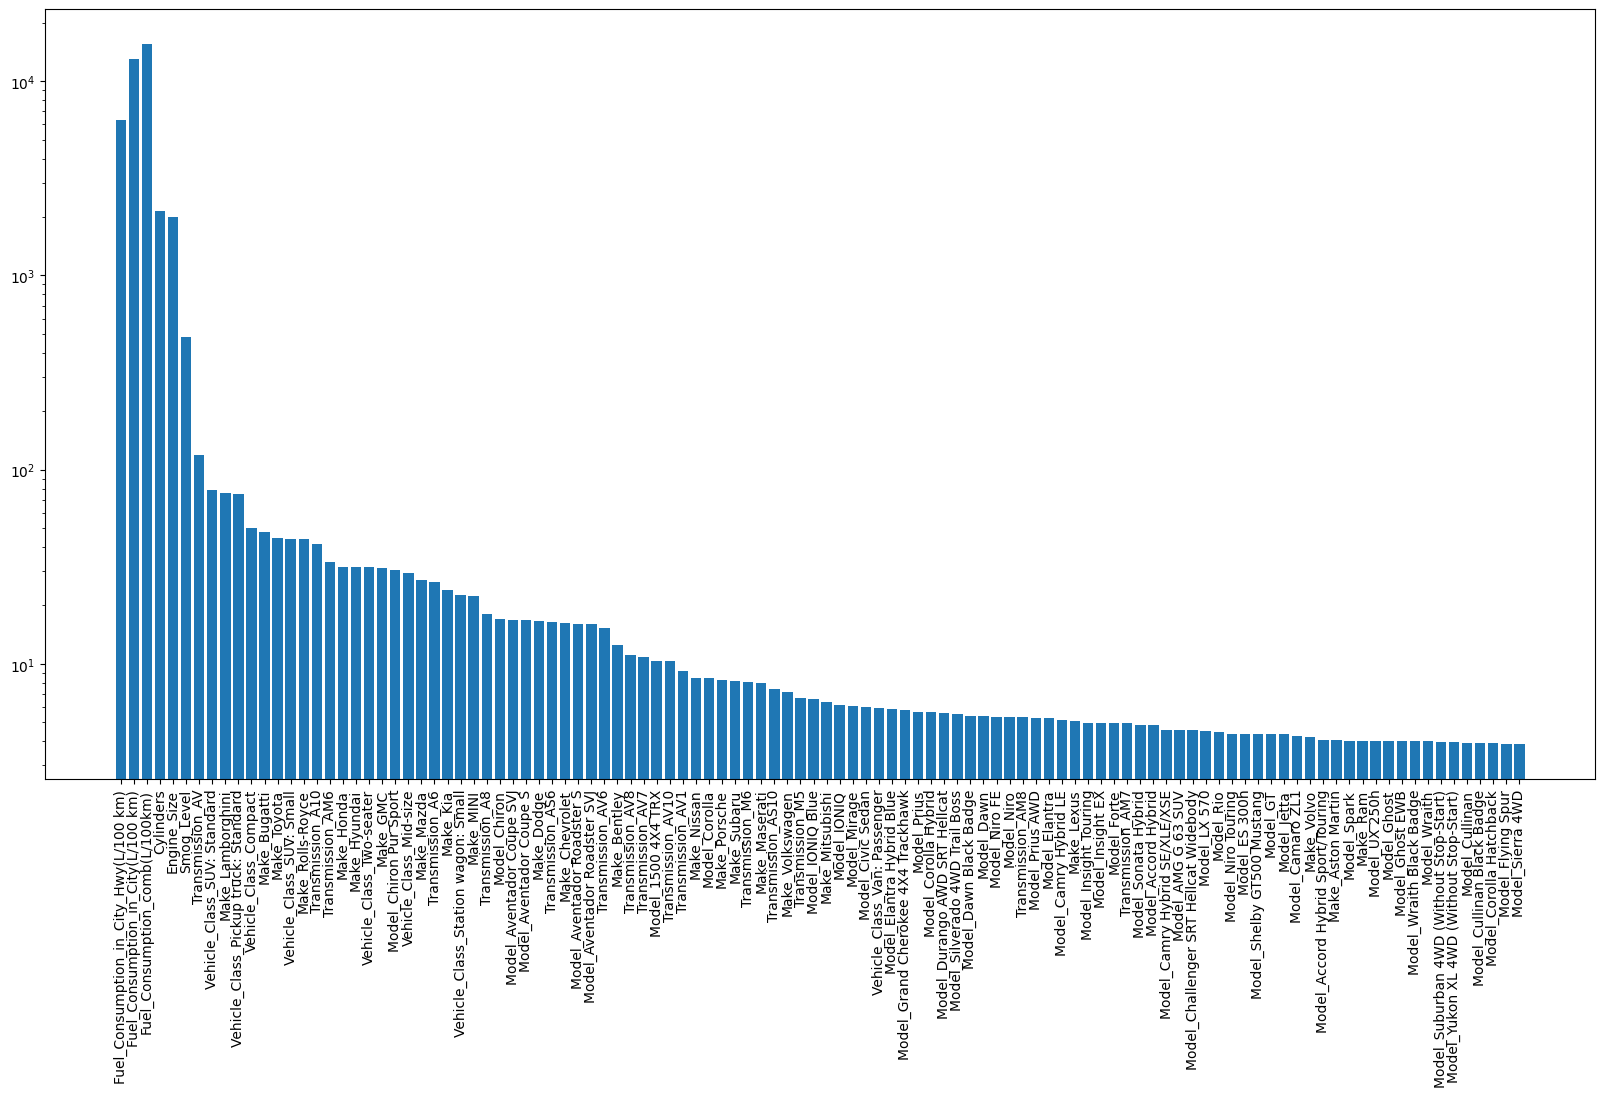

In [37]:
plt.figure(figsize=(20, 10))
plt.bar(results_pass_df['Feature'], results_pass_df['F-value'])
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

#### Valor R de correlación

In [38]:
R = r_regression(X_processed, y, center=True)

results_df = pd.DataFrame({
    'Feature': np.array(pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features).tolist() + numerical_features),
    'Correlation': R
})

results_df = results_df.reindex(results_df['Correlation'].abs().sort_values(ascending=False).index)

results_df

C:\Users\emanuel.novelo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:331: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


,Feature,Correlation
784,Fuel_Consumption_comb(L/100km),0.971241
782,Fuel_Consumption_in_City(L/100 km),0.966137
783,Fuel_Consumption_in_City_Hwy(L/100 km),0.933468
781,Cylinders,0.834972
780,Engine_Size,0.825725
...,...,...
226,Model_Challenger AWD,-0.000269
695,Model_Wrangler JL 4X4 eTorque,-0.000269
54,Model_300 AWD,-0.000269
520,Model_Q60 AWD Red Sport,0.000239


In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(results_df['Feature'], results_df['Correlation'])
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

#ver la grafica bajo tu propio riesgo (skull emoji)

#### Umbral de Varianza

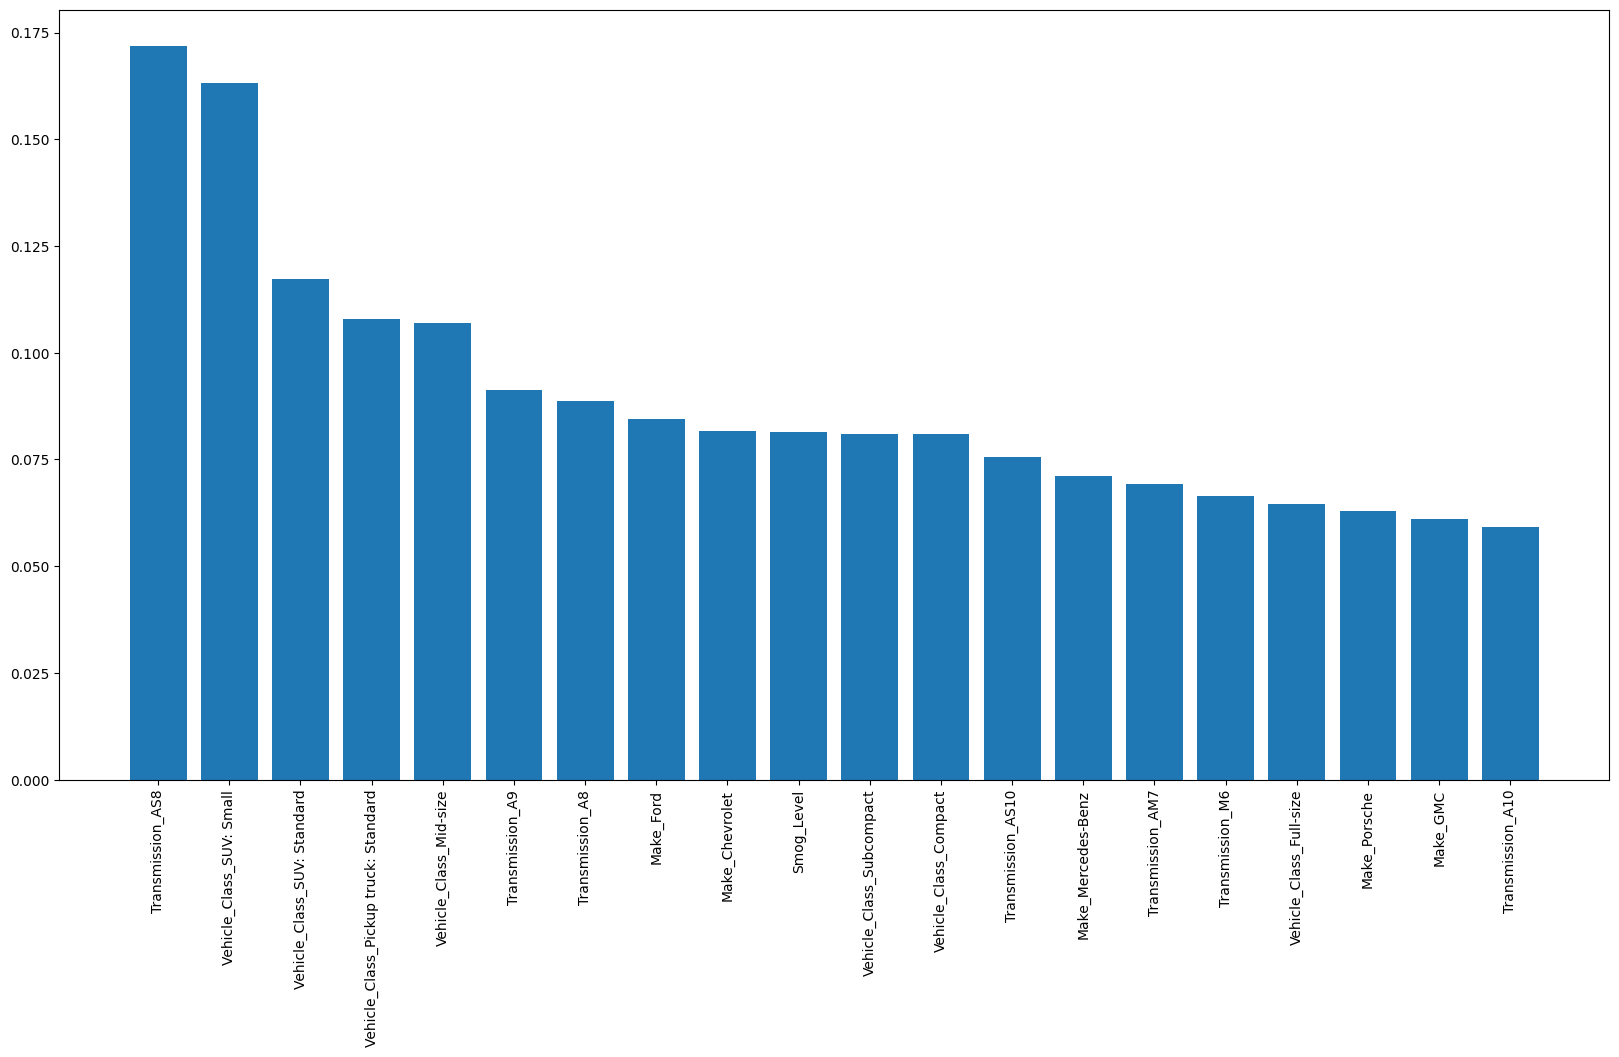

In [43]:
categorical_features = ["Model_Year", "Make", "Model", "Vehicle_Class", "Transmission"]
numerical_features = [col for col in df.columns if col not in categorical_features + ['CO2_Emissions']] 

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', MinMaxScaler(), numerical_features)  # Para normalizar las variables numéricas
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_processed = pipeline.fit_transform(df)

y = df['CO2_Emissions']

selector = VarianceThreshold()
X_selected = selector.fit_transform(X_processed)

# Obtener nombres de las variables seleccionadas
selected_features = np.array(pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features).tolist() + numerical_features)

results_df = pd.DataFrame({
    'Feature': selected_features,
    'Variance': selector.variances_
})

results_df = results_df.sort_values(by='Variance', ascending=False).head(20)

plt.figure(figsize=(20, 10))
plt.bar(results_df['Feature'], results_df['Variance'])
plt.xticks(rotation=90)
plt.show()

#### Información mutua

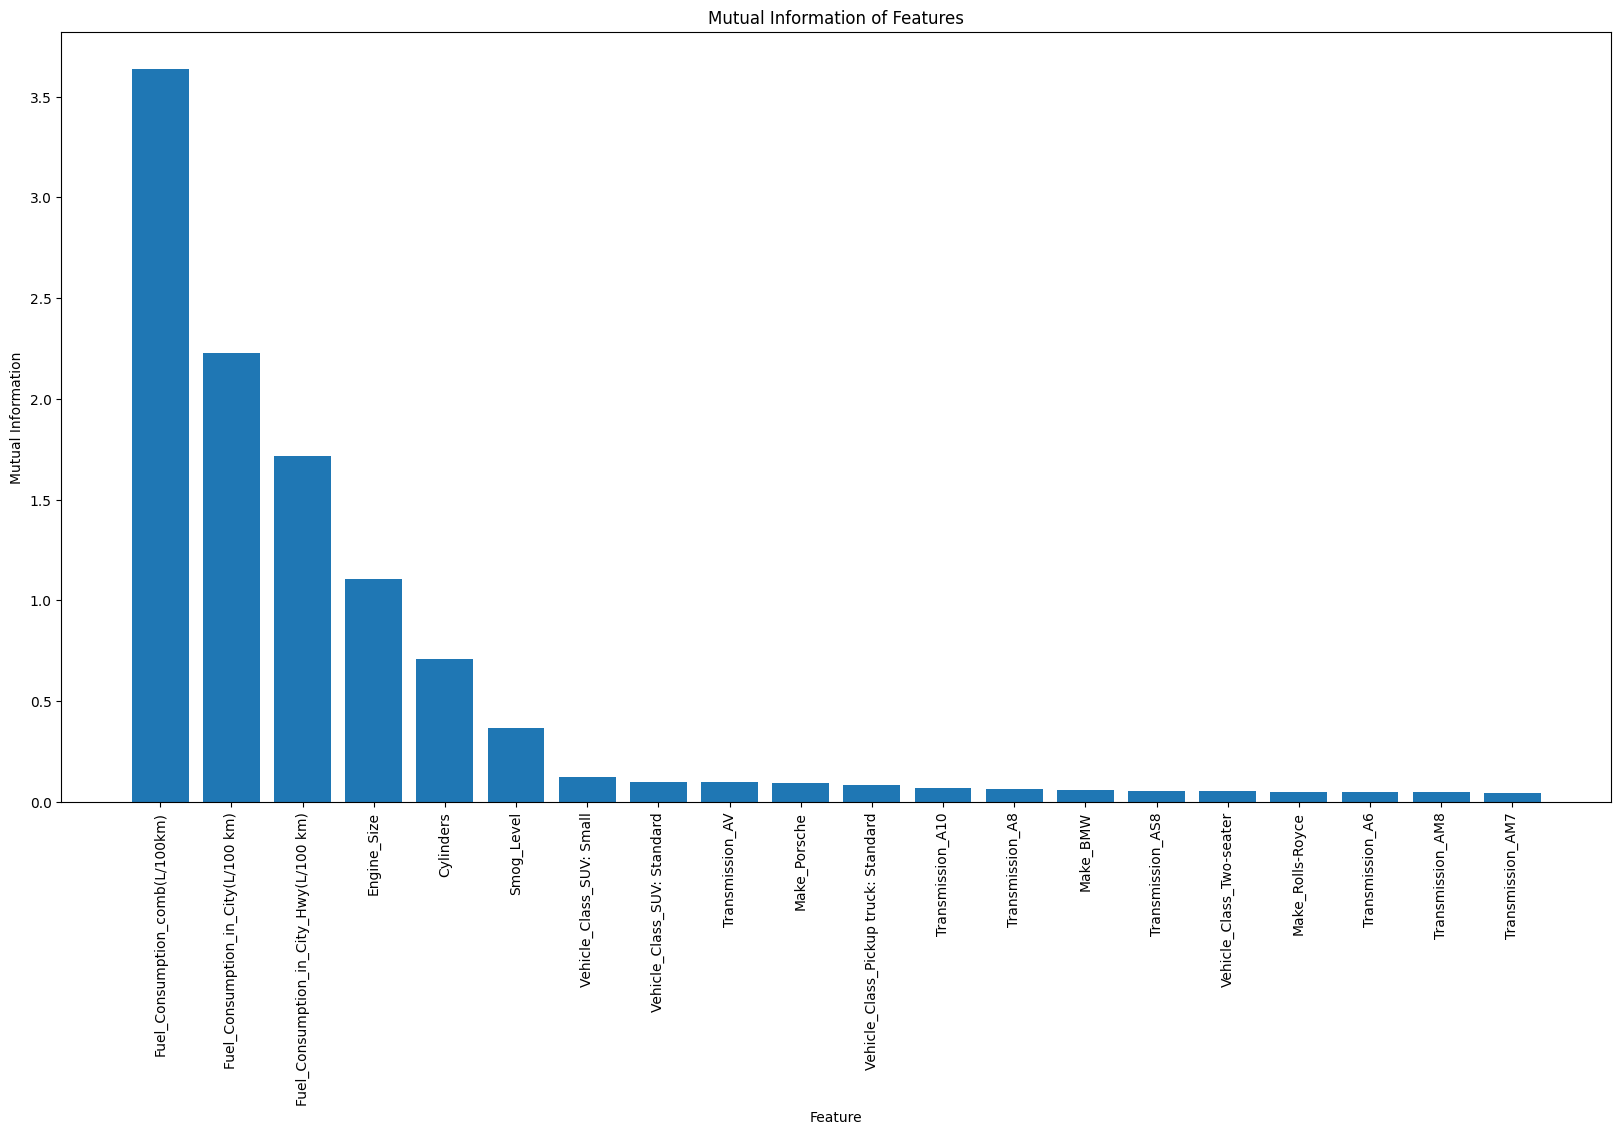

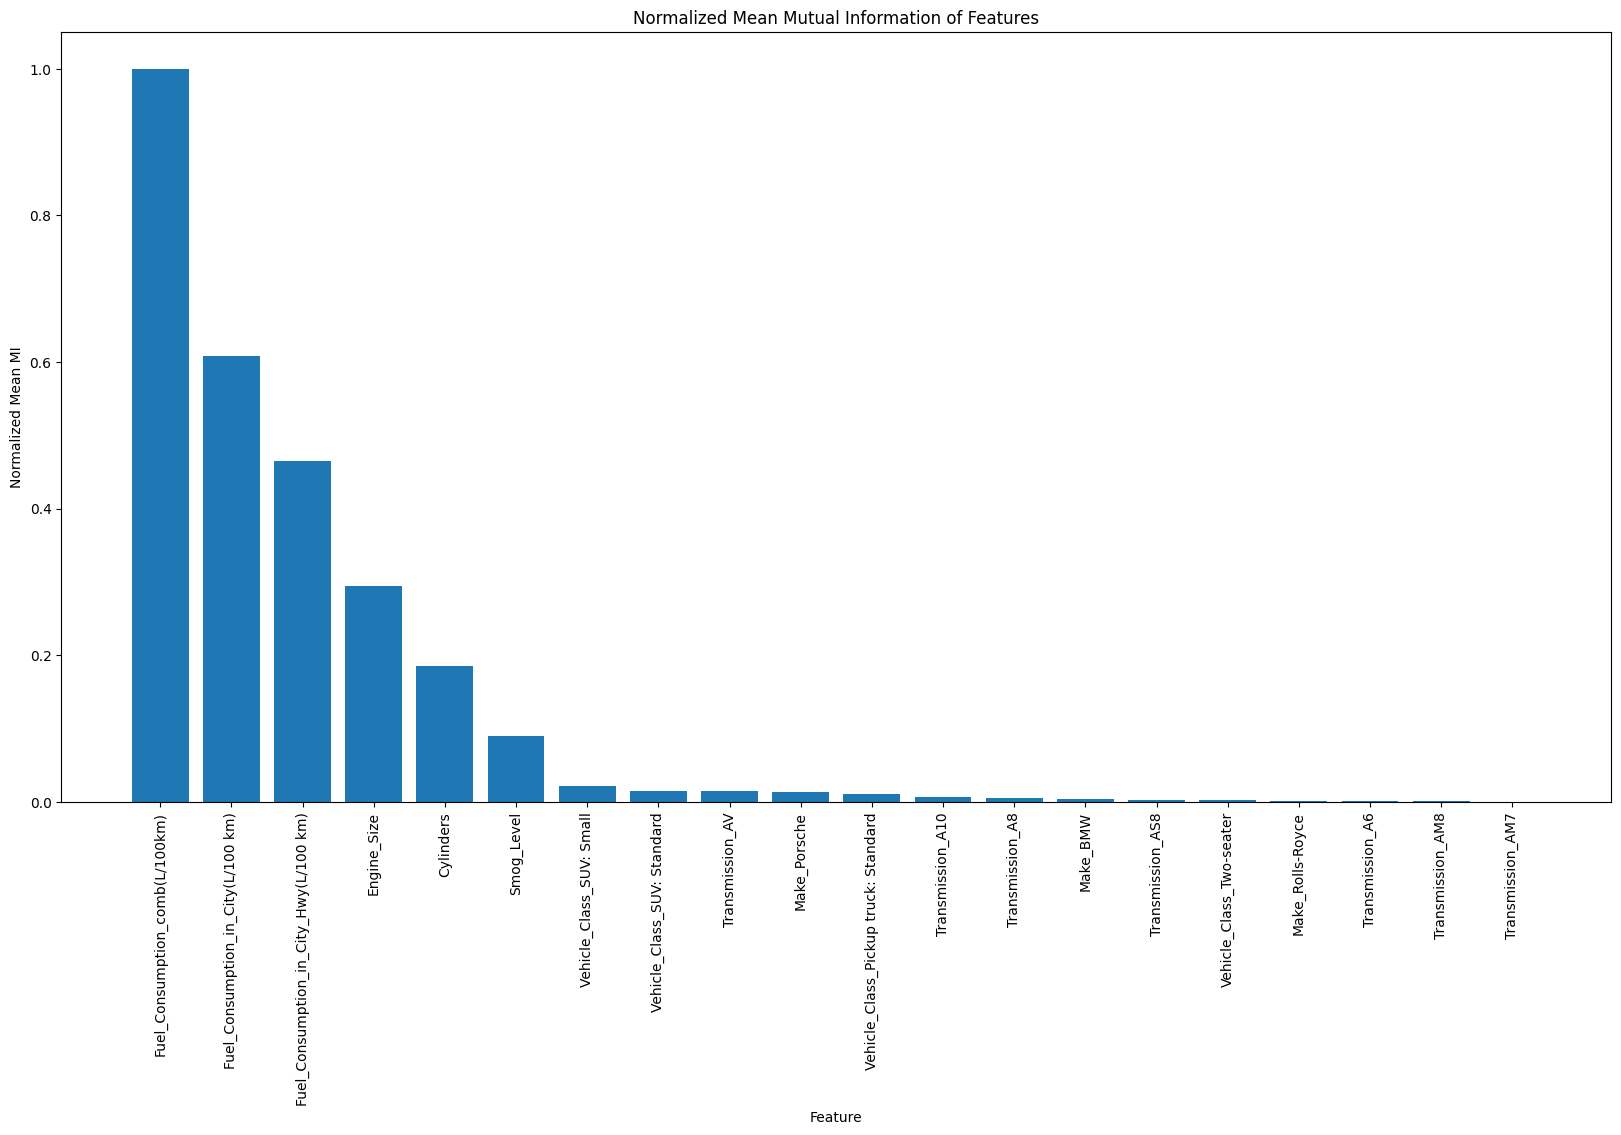

In [46]:
categorical_features = ["Model_Year", "Make", "Model", "Vehicle_Class", "Transmission"]
numerical_features = [col for col in df.columns if col not in categorical_features + ['CO2_Emissions']]  # 'CO2_Emissions' es la variable objetivo

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())]), numerical_features)  # Para manejar valores nulos y normalizar las variables numéricas
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_processed = pipeline.fit_transform(df)

y = df['CO2_Emissions']

mi = mutual_info_regression(X_processed, y, random_state=0)

features = np.array(pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features).tolist() + numerical_features)

results_df = pd.DataFrame({
    'Feature': features,
    'MI': mi
})

results_df = results_df.sort_values(by='MI', ascending=False)
results_df = results_df.head(20)

# Gráfica los resultados de MI
plt.figure(figsize=(20, 10))
plt.bar(results_df['Feature'], results_df['MI'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.title('Mutual Information of Features')
plt.show()

# Reusltados estandarizados y media como criterio de decisión
scaler = MinMaxScaler()
scaled = scaler.fit_transform(results_df[['MI']])
results_df_scaled = pd.DataFrame(scaled, columns=['MI'], index=results_df['Feature'])
results_df_scaled['norm_mean'] = results_df_scaled.mean(axis=1)
results_df_scaled = results_df_scaled.sort_values(by='norm_mean', ascending=False)

plt.figure(figsize=(20, 10))
plt.bar(results_df_scaled.index, results_df_scaled['norm_mean'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Normalized Mean MI')
plt.title('Normalized Mean Mutual Information of Features')
plt.show()

### Métodos de envoltura o wrapper

In [48]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LinearRegression

#### Selección de características exhaustiva

In [57]:
import signal
import time

In [76]:
# Usando df filtrado con mejores caracteristicas de acuerdo a prueba F

categorical_features = ["Model_Year", "Make", "Model", "Vehicle_Class", "Transmission"]

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_categorical = encoder.fit_transform(df[categorical_features])

encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

df_encoded = df.drop(columns=categorical_features).reset_index(drop=True)
df_encoded = pd.concat([df_encoded, encoded_categorical_df], axis=1)

results_pass_df = results_pass_df.head(10) # top 10 features
selected_features = results_pass_df['Feature'].values

selected_features = np.append(selected_features, 'CO2_Emissions')

df_selected = df_encoded[selected_features]

df_selected

,Fuel_Consumption_in_City_Hwy(L/100 km),Fuel_Consumption_in_City(L/100 km),Fuel_Consumption_comb(L/100km),Cylinders,Engine_Size,Smog_Level,Transmission_AV,Vehicle_Class_SUV: Standard,Make_Lamborghini,Vehicle_Class_Pickup truck: Standard,CO2_Emissions
0,7.0,9.9,8.6,4,2.4,3,0.0,0.0,0.0,0.0,199
1,10.8,11.1,11.0,6,3.5,3,0.0,0.0,0.0,0.0,256
2,8.6,11.0,9.9,4,2.0,6,0.0,0.0,0.0,0.0,232
3,9.1,11.3,10.3,4,2.0,6,0.0,0.0,0.0,0.0,242
4,8.0,11.2,9.8,4,2.0,7,0.0,0.0,0.0,0.0,230
...,...,...,...,...,...,...,...,...,...,...,...
930,7.7,10.7,9.4,4,2.0,5,0.0,0.0,0.0,0.0,219
931,8.3,11.1,9.9,4,2.0,5,0.0,0.0,0.0,0.0,230
932,8.6,11.7,10.3,4,2.0,7,0.0,0.0,0.0,0.0,240
933,8.4,11.5,10.1,4,2.0,5,0.0,1.0,0.0,0.0,236


Features: 967/967

Best MAE score: -6.35
Best subset (corresponding names): Index(['Fuel_Consumption_comb(L/100km)'], dtype='object')
      feature_idx                                          cv_scores  \
2            (2,)  [-4.852742655659798, -10.06132544776002, -7.43...   
33         (2, 9)  [-4.677151912615896, -10.033815621748396, -7.9...   
30         (2, 6)  [-5.166898576908581, -10.081386565836368, -7.4...   
31         (2, 7)  [-4.989205797891324, -10.18254451302256, -7.26...   
19         (1, 2)  [-4.6892697355025, -10.354637481489478, -7.506...   
10         (0, 1)  [-4.713470117346921, -10.297034810738792, -7.4...   
32         (2, 8)  [-5.164851816219906, -10.080306433715483, -7.4...   
11         (0, 2)  [-4.687102513567888, -10.34269081474865, -7.53...   
55      (0, 1, 2)  [-4.687316781937574, -10.312268281865041, -7.5...   
136     (2, 6, 9)  [-5.012411010961931, -10.055599306310647, -8.0...   
97      (1, 2, 9)  [-4.604921580965969, -10.266739601804325, -7.9...   
138     (2, 7, 9)  [-

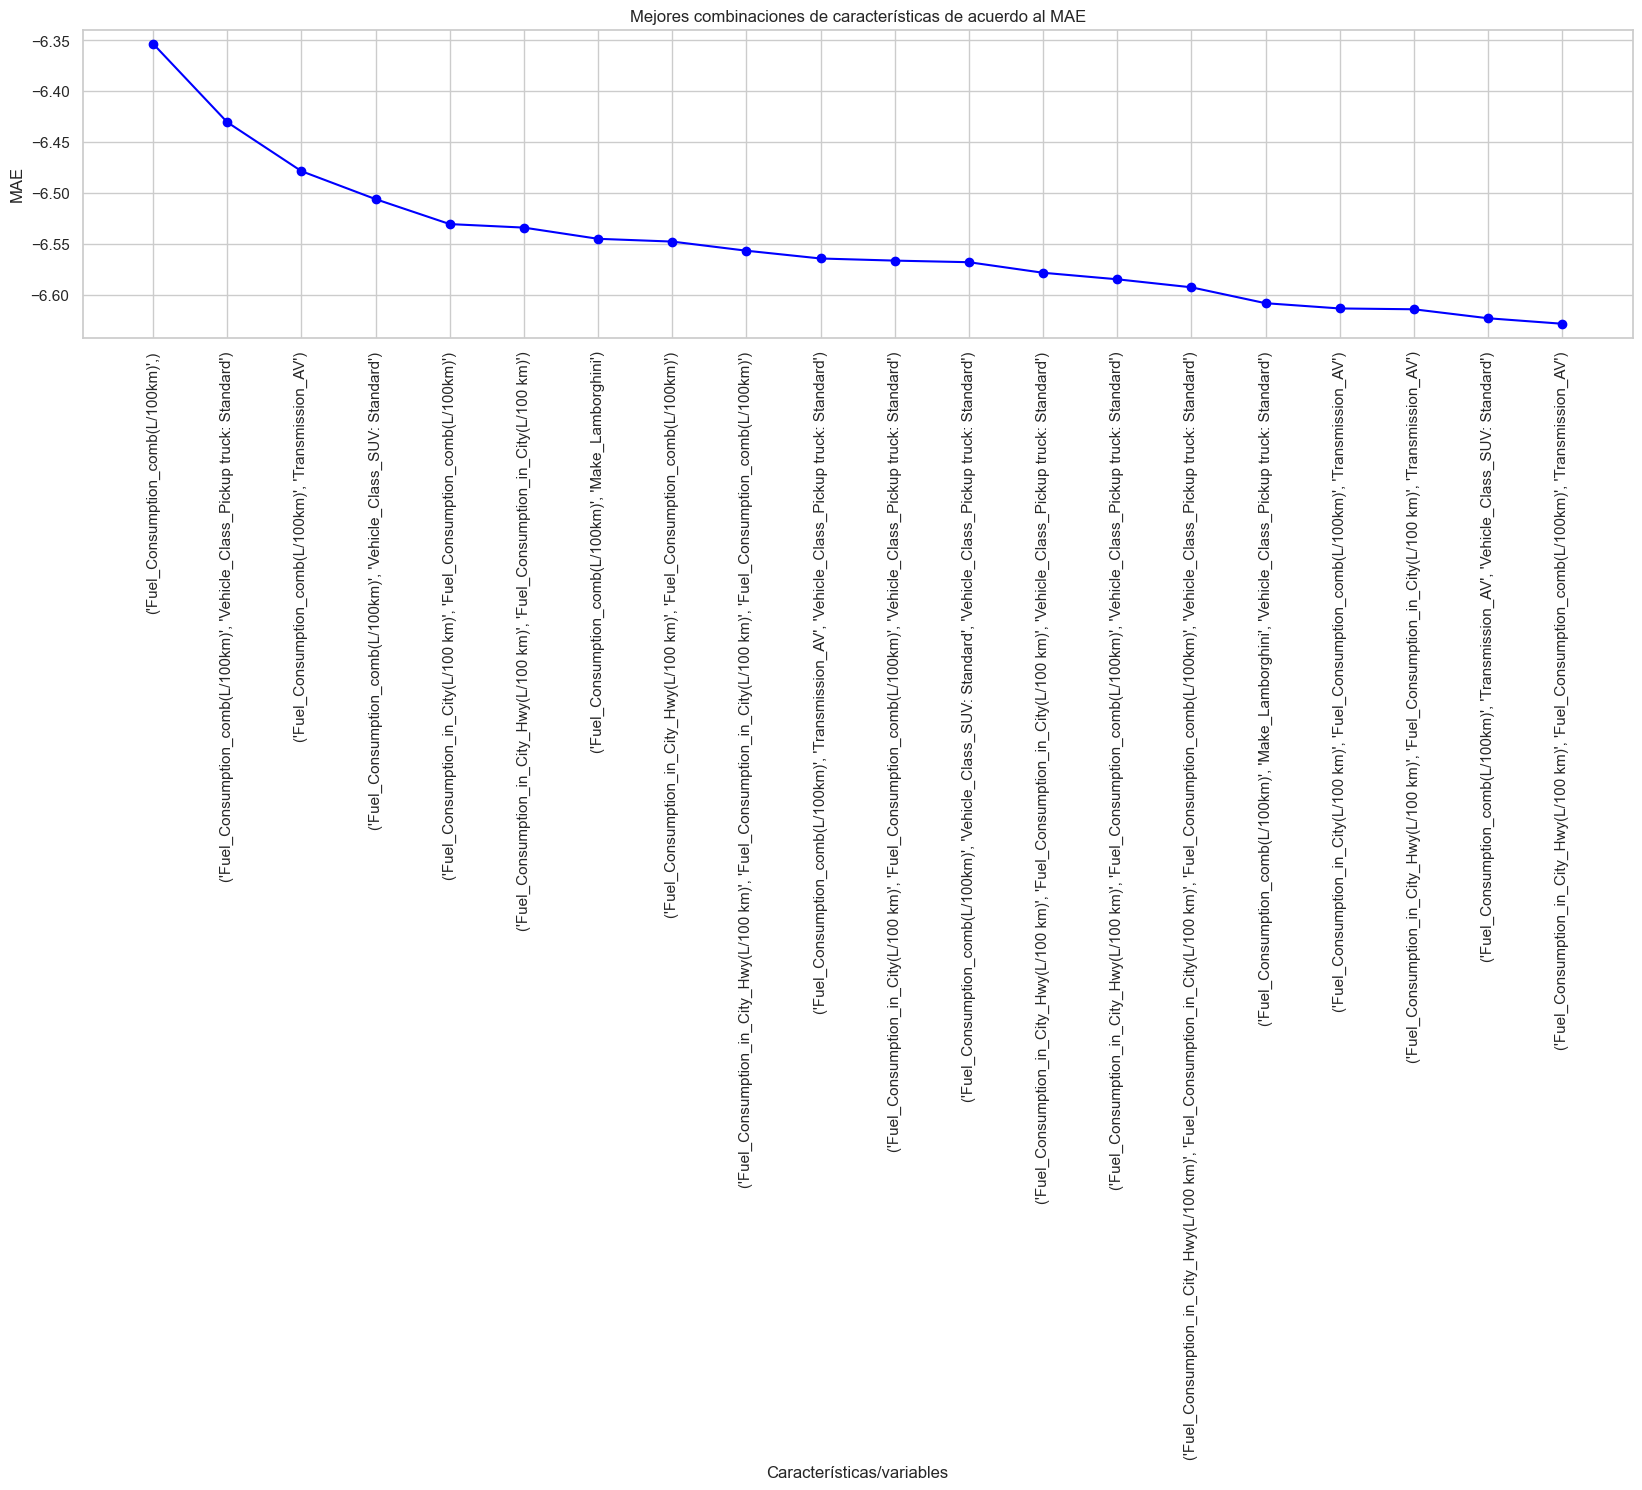

In [80]:
X_processed = df_selected.drop(['CO2_Emissions'], axis=1)

y = df_selected['CO2_Emissions']

scaler = MinMaxScaler()
X_processed[X_processed.columns] = scaler.fit_transform(X_processed)

# Modelo de regresión lineal
lr = LinearRegression()

# Búsqueda exhaustiva
efs = EFS(estimator=lr,
          min_features=1,
          max_features=7,
          scoring='neg_mean_absolute_error',
          cv=5)

efs = efs.fit(X_processed, y)

# Mejores variables
selected_features = X_processed.columns[list(efs.best_idx_)]

print('Best MAE score: %.2f' % efs.best_score_)
print('Best subset (corresponding names):', selected_features)

metric_dict = efs.get_metric_dict()
df_efs = pd.DataFrame(metric_dict).T
df_efs.sort_values('avg_score', ascending=False, inplace=True)

# 20 mejores combinaciones
df_efs_best_20 = df_efs.iloc[:20]

# Mostrar los resultados de las mejores 20 combinaciones
print(df_efs_best_20)

fig = plt.figure(figsize=(20, 4))
plt.plot(
    df_efs_best_20.feature_names.astype(str), 
    df_efs_best_20.avg_score, 
    color='blue', marker='o'
)
plt.ylabel('MAE')
plt.xlabel('Características/variables')
plt.xticks(rotation=90)
plt.title('Mejores combinaciones de características de acuerdo al MAE')
plt.show()

#### SFS

Best MAE score (SFS): -6.99
Best subset (SFS): Index(['Fuel_Consumption_in_City_Hwy(L/100 km)',
       'Fuel_Consumption_in_City(L/100 km)', 'Fuel_Consumption_comb(L/100km)',
       'Smog_Level', 'Transmission_AV', 'Make_Lamborghini',
       'Vehicle_Class_Pickup truck: Standard'],
      dtype='object')
             feature_idx                                          cv_scores  \
1                   (2,)  [-4.852742655659798, -10.06132544776002, -7.43...   
2                 (2, 9)  [-4.677151912615896, -10.033815621748396, -7.9...   
3              (2, 6, 9)  [-5.012411010961931, -10.055599306310647, -8.0...   
4           (1, 2, 6, 9)  [-4.938867531075896, -10.276667298536879, -7.8...   
5        (0, 1, 2, 6, 9)  [-4.937045409069576, -10.237594917515787, -7.9...   
6     (0, 1, 2, 6, 8, 9)  [-5.254306200325706, -10.236869334071566, -7.9...   
7  (0, 1, 2, 5, 6, 8, 9)  [-5.092952025501972, -10.71060067098409, -8.41...   

  avg_score                                      feature_names

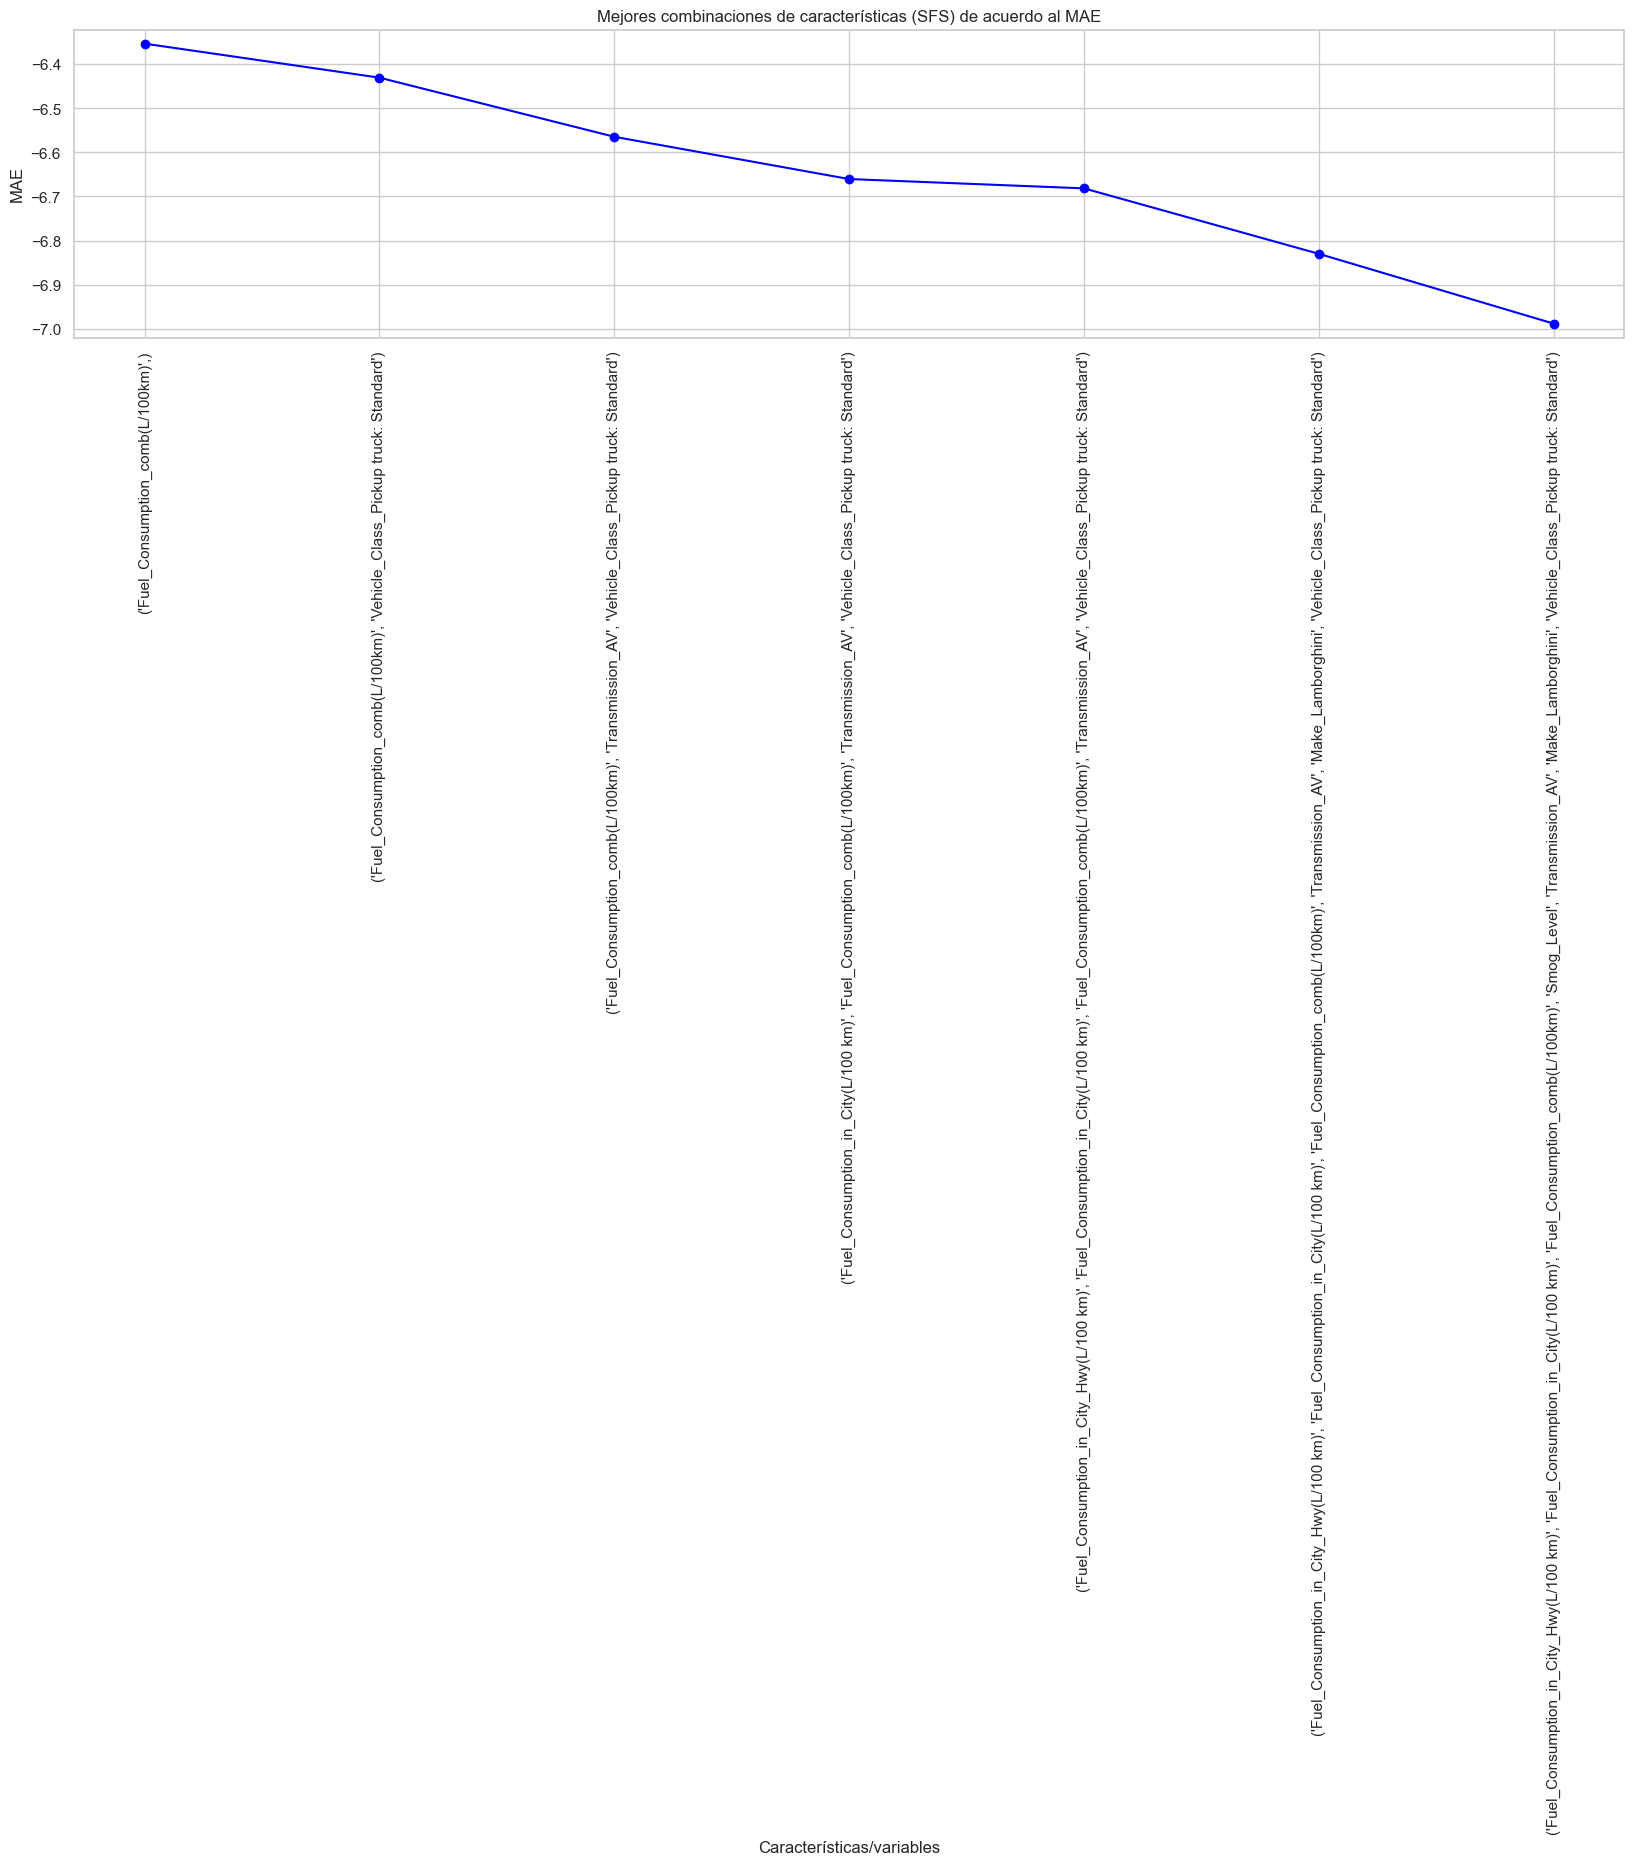

In [82]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

X_processed = df_selected.drop(['CO2_Emissions'], axis=1)

y = df_selected['CO2_Emissions']

scaler = MinMaxScaler()
X_processed[X_processed.columns] = scaler.fit_transform(X_processed)

lr = LinearRegression()

sfs = SFS(estimator=lr,
          k_features=7,
          forward=True,
          floating=False,
          scoring='neg_mean_absolute_error',
          cv=5)

sfs = sfs.fit(X_processed, y)

# Mejores variables
selected_features_sfs = X_processed.columns[list(sfs.k_feature_idx_)]

print('Best MAE score (SFS): %.2f' % sfs.k_score_)
print('Best subset (SFS):', selected_features_sfs)

metric_dict_sfs = sfs.get_metric_dict()
df_sfs = pd.DataFrame(metric_dict_sfs).T
df_sfs.sort_values('avg_score', ascending=False, inplace=True)

# Top 20 combinaciones
df_sfs_best_20 = df_sfs.iloc[:20]

print(df_sfs_best_20)

fig = plt.figure(figsize=(20, 4))
plt.plot(
    df_sfs_best_20.feature_names.astype(str), 
    df_sfs_best_20.avg_score, 
    color='blue', marker='o'
)
plt.ylabel('MAE')
plt.xlabel('Características/variables')
plt.xticks(rotation=90)
plt.title('Mejores combinaciones de características (SFS) de acuerdo al MAE')
plt.show()

#### SBS

Best MAE score (SBS): -7.04
Best subset (SBS): Index(['Fuel_Consumption_in_City_Hwy(L/100 km)',
       'Fuel_Consumption_in_City(L/100 km)', 'Fuel_Consumption_comb(L/100km)',
       'Cylinders', 'Engine_Size', 'Vehicle_Class_SUV: Standard',
       'Vehicle_Class_Pickup truck: Standard'],
      dtype='object')
                       feature_idx  \
7            (0, 1, 2, 3, 4, 7, 9)   
8         (0, 1, 2, 3, 4, 7, 8, 9)   
9      (0, 1, 2, 3, 4, 5, 7, 8, 9)   
10  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   

                                            cv_scores avg_score  \
7   [-5.266853602067472, -10.656056300218605, -8.1... -7.041341   
8   [-5.270220522126648, -10.666065765945417, -8.1... -7.162165   
9   [-6.381925755651909, -10.654203277705088, -8.5... -7.292437   
10  [-6.632402494302495, -10.64894350842403, -8.56... -7.438514   

                                        feature_names  ci_bound   std_dev  \
7   (Fuel_Consumption_in_City_Hwy(L/100 km), Fuel_...  2.818542  2.192922   
8   (Fue

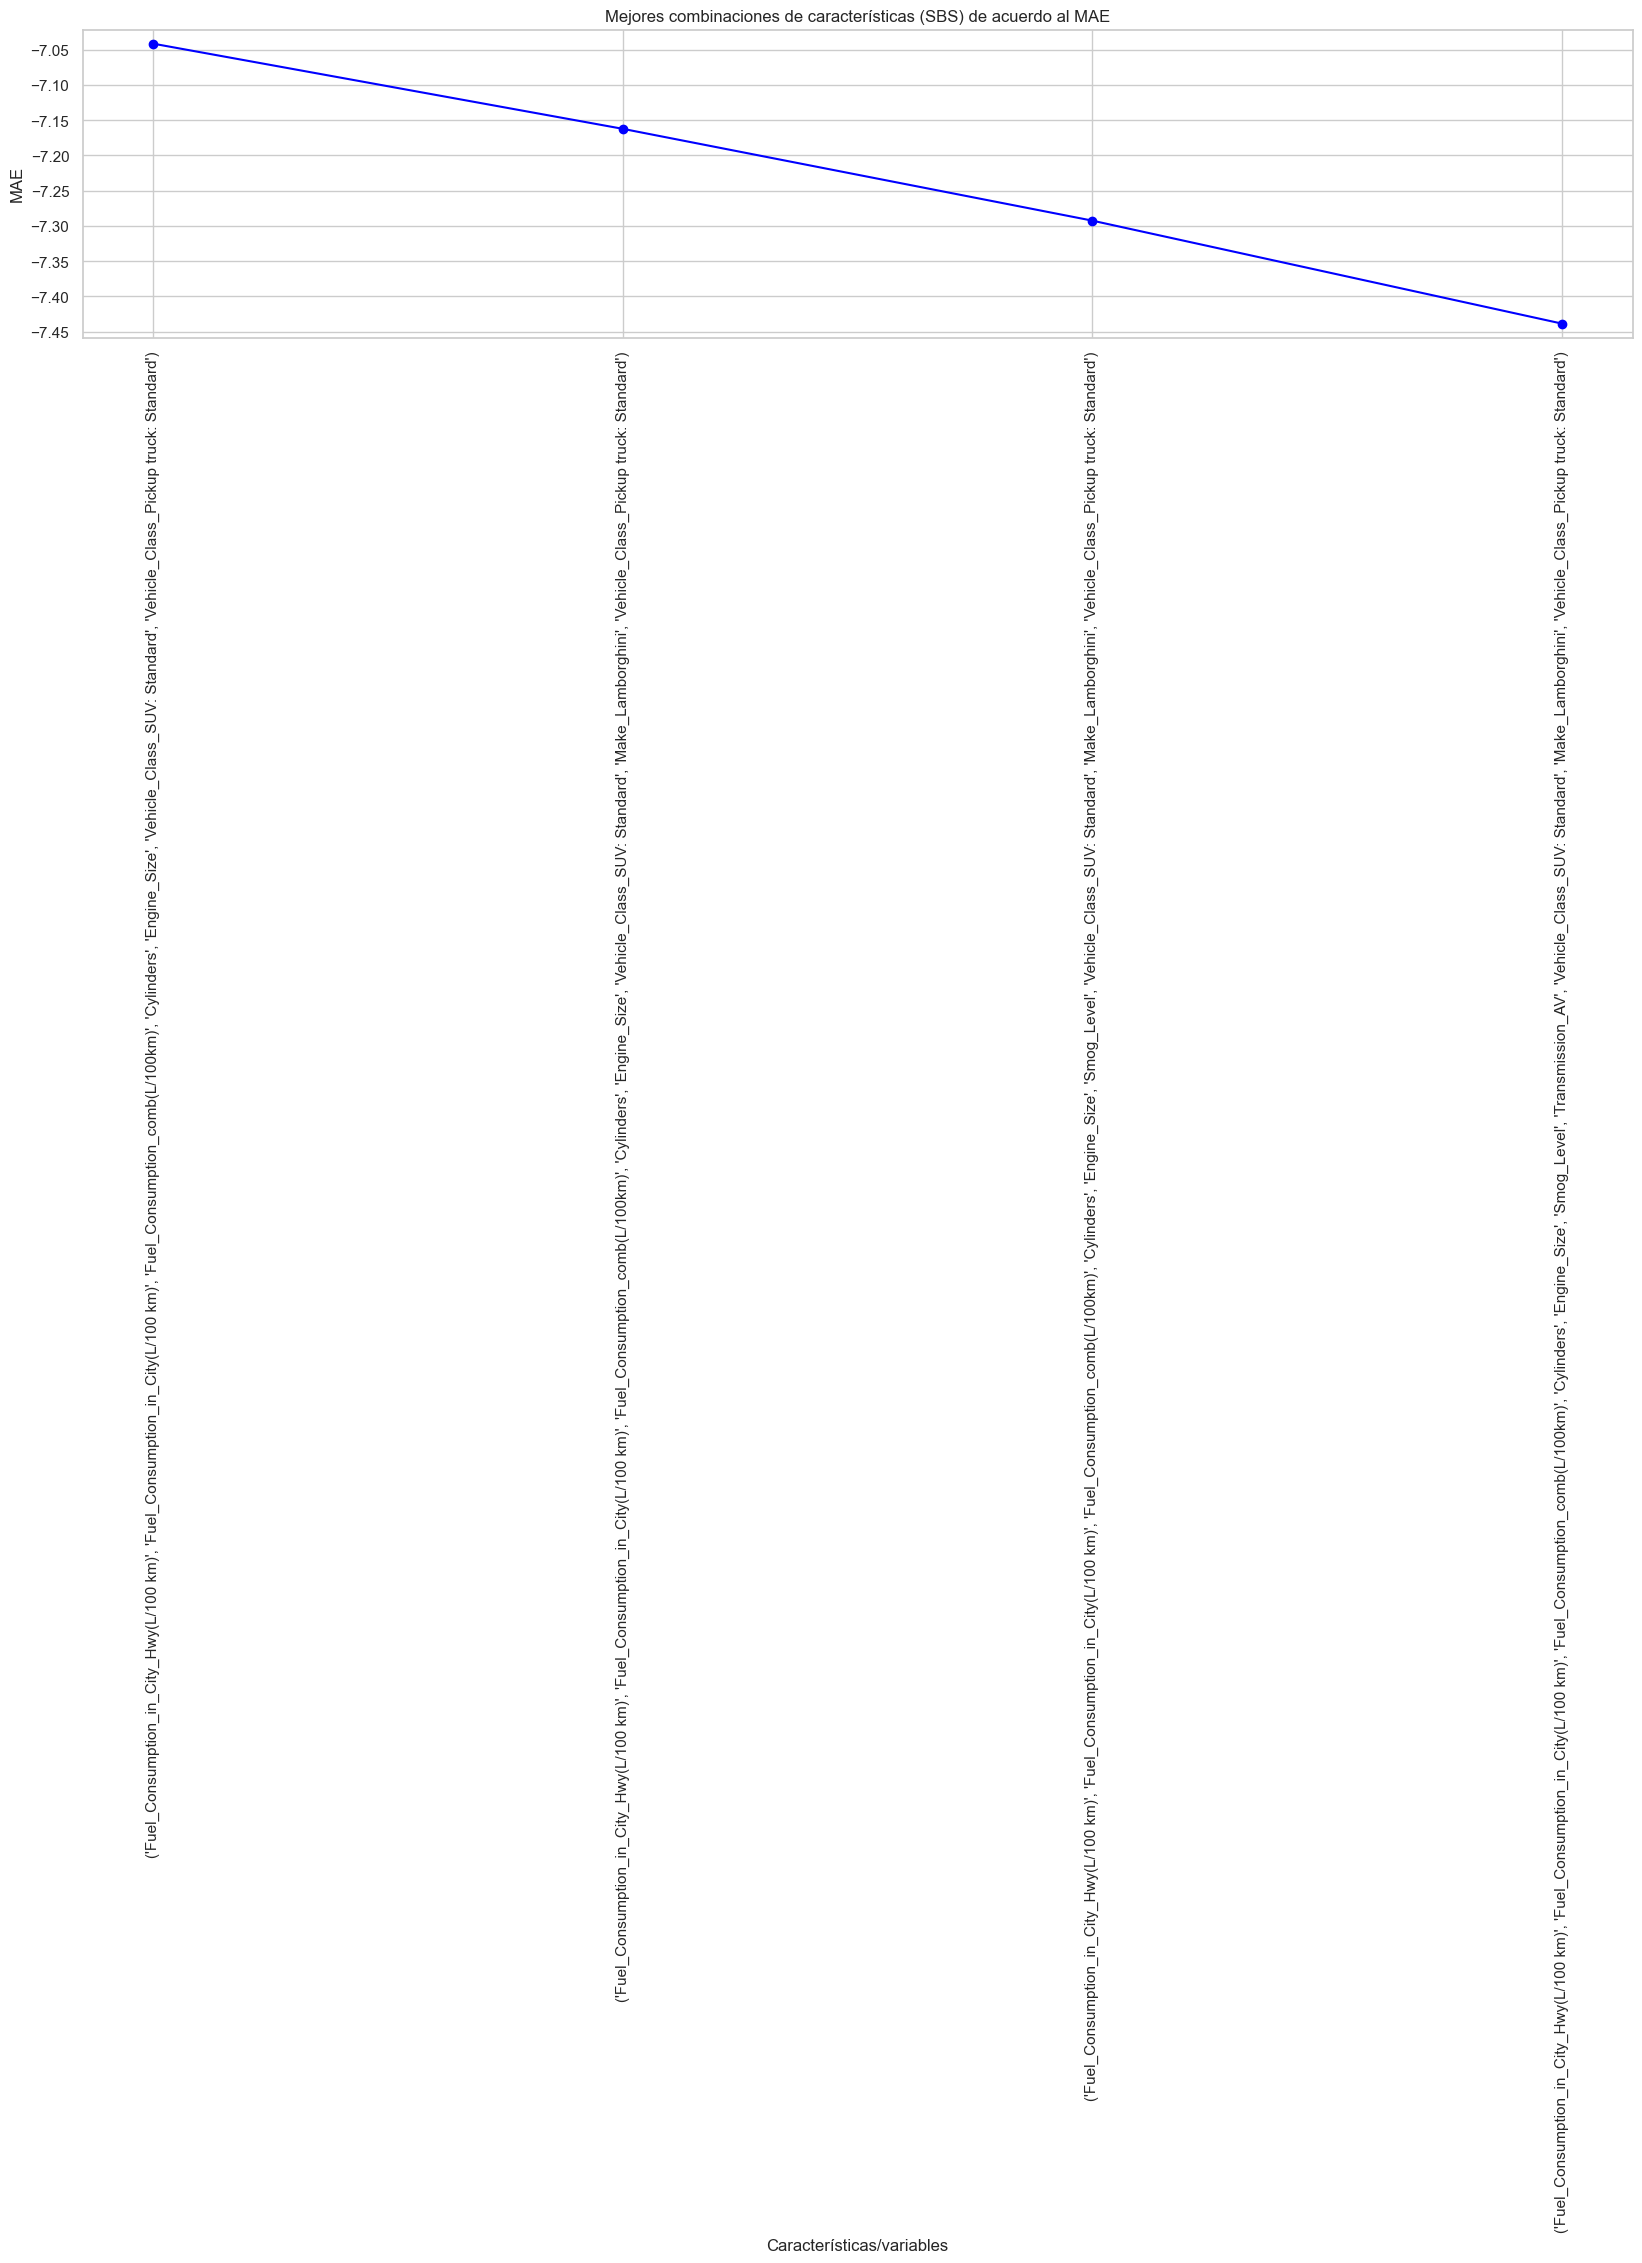

In [83]:
sbs = SFS(estimator=lr,
          k_features=7,
          forward=False,
          floating=False,
          scoring='neg_mean_absolute_error',
          cv=5)

sbs = sbs.fit(X_processed, y)

# Mejores variables
selected_features_sbs = X_processed.columns[list(sbs.k_feature_idx_)]

print('Best MAE score (SBS): %.2f' % sbs.k_score_)
print('Best subset (SBS):', selected_features_sbs)

metric_dict_sbs = sbs.get_metric_dict()
df_sbs = pd.DataFrame(metric_dict_sbs).T
df_sbs.sort_values('avg_score', ascending=False, inplace=True)

# Top 20 combinaciones
df_sbs_best_20 = df_sbs.iloc[:20]

print(df_sbs_best_20)

fig = plt.figure(figsize=(20, 4))
plt.plot(
    df_sbs_best_20.feature_names.astype(str), 
    df_sbs_best_20.avg_score, 
    color='blue', marker='o'
)
plt.ylabel('MAE')
plt.xlabel('Características/variables')
plt.xticks(rotation=90)
plt.title('Mejores combinaciones de características (SBS) de acuerdo al MAE')
plt.show()

#### PCA

In [85]:
from sklearn.decomposition import PCA

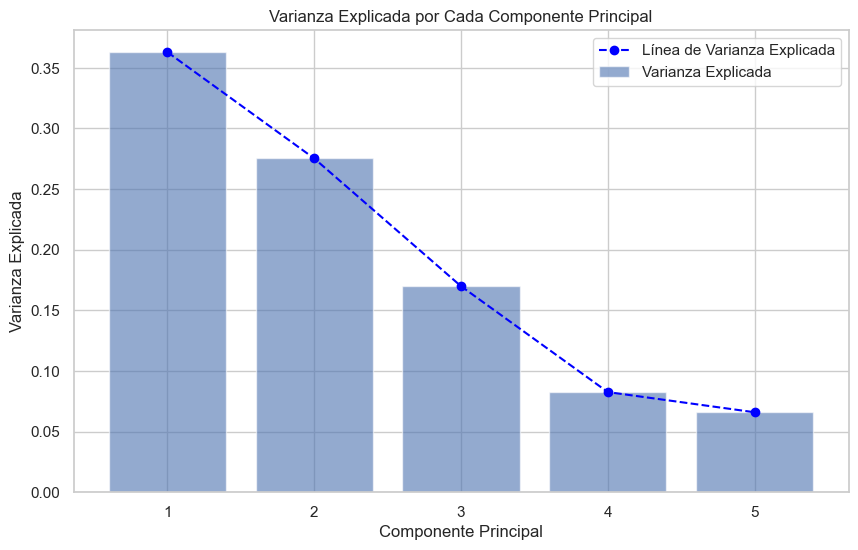

     Fuel_Consumption_in_City_Hwy(L/100 km)  \
PC1                                0.267789   
PC2                                0.038563   
PC3                               -0.009121   
PC4                               -0.059150   
PC5                                0.193867   

     Fuel_Consumption_in_City(L/100 km)  Fuel_Consumption_comb(L/100km)  \
PC1                            0.278345                        0.274959   
PC2                            0.040520                        0.039954   
PC3                           -0.086147                       -0.060001   
PC4                           -0.072441                       -0.067758   
PC5                            0.245276                        0.226632   

     Cylinders  Engine_Size  Smog_Level  Transmission_AV  \
PC1   0.304127     0.410115   -0.484326        -0.161985   
PC2   0.035038     0.078011    0.015724        -0.031801   
PC3  -0.089505    -0.044228    0.583467         0.103173   
PC4   0.025361     0.03754

In [87]:
X = df_selected.drop(['CO2_Emissions'], axis=1)
y = df_selected['CO2_Emissions']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza explicada
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
components = np.arange(1, len(explained_variance) + 1)
plt.bar(components, explained_variance, alpha=0.6, label='Varianza Explicada')
plt.plot(components, explained_variance, marker='o', linestyle='--', color='blue', label='Línea de Varianza Explicada')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Cada Componente Principal')
plt.legend()
plt.show()

# Df de coeficientes del PCA
pca_components_df = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])

print(pca_components_df)

### CO2 Emissions Feature Selection & la Literatura

Citando la investigación de Hang Thi y Jeonghan Ko de Febrero de 2024, llamada *Effective Modeling of CO2Emissions for Light-Duty Vehicles:Linear and Non-Linear Models with Feature Selection*
se menciona lo siguieinte: "Excluding irrelevant or less important variables from a multiple regression model
is critical for model efficiency and interpretation of results. Numerous studies have incorporated feature selection techniques such as forward and backward selection in linear
models [15,16] and have successfully improved model accuracy and removed irrelevant
features."
En la data referenciada en el artículo justamente se usan variables en común con mi conjunto de datos, por lo que resulta muy apropiada la lectura.
El paper se puede leer [aquí](/Docs/Effective_Modeling_of_CO2_Emissions_for_Light-Duty.pdf)

En las pruebas realizadas en este notebook, se probó el SFS y SBS coincidentemente sobre modelos de regresión lineal, por lo que se mencionan a continuación las conclusiones de la selección de características realizadas

#### Conclusiones

En el SBS el mejor subset de variables fue:

Best MAE score (SBS): -7.04
Best subset (SBS): Index(['Fuel_Consumption_in_City_Hwy(L/100 km)',
       'Fuel_Consumption_in_City(L/100 km)', 'Fuel_Consumption_comb(L/100km)',
       'Cylinders', 'Engine_Size', 'Vehicle_Class_SUV: Standard',
       'Vehicle_Class_Pickup truck: Standard']

En el SFS el mejor subset de variables fue:

Best MAE score (SFS): -6.99
Best subset (SFS): Index(['Fuel_Consumption_in_City_Hwy(L/100 km)',
       'Fuel_Consumption_in_City(L/100 km)', 'Fuel_Consumption_comb(L/100km)',
       'Smog_Level', 'Transmission_AV', 'Make_Lamborghini',
       'Vehicle_Class_Pickup truck: Standard'],
      dtype='object')

Aunque hay que tomar en cuenta que debido al costo computacional de probar el SBS y el SFS en el df completo con sus >700 variables, se redujo la dimnensionalidad para tomar en cuenta solo las top 10 variables sugeridas por la prueba F

Finalmente, hay que señalar que el consumo de combustible en ciuedad está presente como un factor determinante en las emisiones de CO2, así como variables relacionadas al motor. Algo interesante es que del SBS salió el fabricante Lamborghini como un elemento que influye considerablemente en las emisiones de CO2. Es complejo determinar por qué las demás variables no fueron elegidas, ya que en realidad casi todas tienen un cierto grado de aporte en las emisiones, sin embargo confiando en los supuestos de los métodos de selección probados, concluimos que las variables mostradas por el SBS y el SFS son las de mayor influencia